In [9]:
import pixellib
import cv2
import numpy as np
from pixellib.torchbackend.instance import instanceSegmentation

from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import applications


In [10]:
ins = instanceSegmentation()
ins.load_model("/content/drive/MyDrive/UniformClassification/pointrend_resnet50.pkl")

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


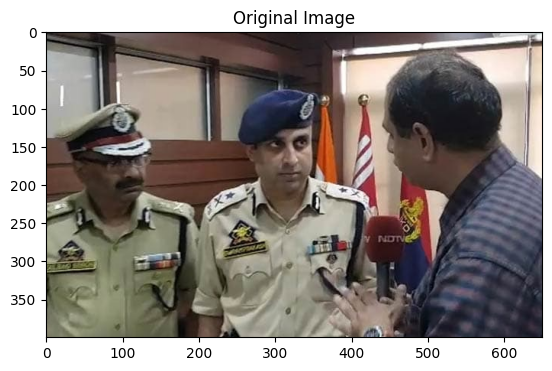

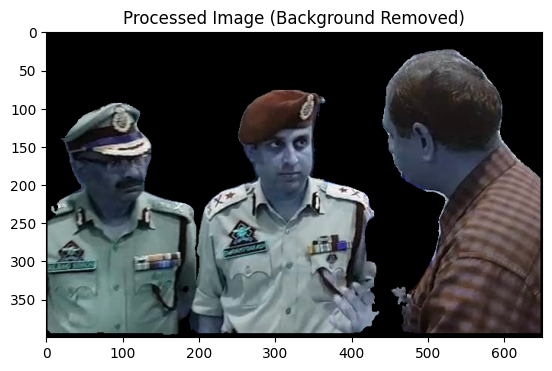

1/1 [==============================] - 1s 1s/step
Predicted Class: J_K


In [11]:
def get_person_reduced_mask(results, threshold=80):
    """Extract masks for persons with confidence scores above the threshold and combine all the masks"""

    transposed_mask = np.transpose(results["masks"], (2, 0, 1))

    req_transposed_mask = [
        mask for mask, class_id, score in zip(transposed_mask, results["class_ids"], results["scores"])
        if class_id == 0 and score > threshold
    ]

    binary_mask = np.logical_or.reduce(req_transposed_mask, axis=0)

    return binary_mask

def remove_background(image_path, threshold=80):
    """Apply a mask for persons with confidence scores above the threshold to the input image."""

    # path to save images
    processed_image_path = image_path.replace('simple_images', 'processed_image')
    segmented_image_path = image_path.replace('simple_images', 'segmented_image')

    # Read the image
    image = cv2.imread(image_path)

    # Get the binary mask for persons
    results, _ = ins.segmentImage(image_path, show_bboxes=True, output_image_name=segmented_image_path)
    binary_mask = get_person_reduced_mask(results, threshold)

    # Ensure the mask is binary
    binary_mask = np.uint8(binary_mask)

    # Expand the selected channel to cover all channels in the image
    expanded_mask = np.expand_dims(binary_mask, axis=-1)

    # Multiply the image with the expanded mask to keep only the foreground
    result = image * expanded_mask

    cv2.imwrite(processed_image_path, result)

    return result

def preprocess_image(image_path, model_input_size=(224, 224)):
    """Preprocess the image by removing the background, resizing, and applying MobileNetV2 preprocessing."""

    # Remove background
    image_no_bg = remove_background(image_path)

    # Resize and preprocess the image
    image_preprocessed = cv2.resize(image_no_bg, (224, 224))
    image_preprocessed = applications.mobilenet_v2.preprocess_input(image_preprocessed)

    return image_preprocessed

# Path to an image for testing
test_image_path = "/content/drive/MyDrive/UniformClassification/simple_images/J&K Police/J&K Police_29.jpg"

# Load the image
test_image = Image.open(test_image_path)
plt.imshow(test_image)
plt.title("Original Image")
plt.show()

# Remove the background
processed_image = remove_background(test_image_path)

# Display the processed image
plt.imshow(processed_image)
plt.title("Processed Image (Background Removed)")
plt.show()

# Preprocess the image for classification
preprocessed_image = preprocess_image(test_image_path)


# Load the model
model = load_model('/content/drive/MyDrive/UniformClassification/best_model.h5')

# Make predictions on the preprocessed image
prediction = model.predict(np.expand_dims(preprocessed_image, axis=0))

# Decode the prediction
class_labels = ['CRPF', 'BSF', 'J_K', 'Random']
predicted_class = class_labels[np.argmax(prediction)]

print(f"Predicted Class: {predicted_class}")